In [1]:
import os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc; gc.enable()
from collections import defaultdict
from sklearn import metrics
from scipy import signal
from scipy.io import wavfile as wf

tf.logging.set_verbosity(tf.logging.ERROR)

### Define number of classes

In [2]:
NUM_CLASSES = 11

### Set path variables

In [3]:
train_dir = './train/audio/'
test_dir = './test/audio/'

In [5]:
train_folders = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [12]:
noise_files = os.listdir(train_dir + '/' + '_background_noise_')

### Log spectogram function

In [4]:
def log_spectrogram(wav, sample_rate, window_size=20, step_size=10, eps=1e-10, spec_only=False):
    
    # crop sample array if length is not 16000
    if len(wav) < 16000:
        
        pad_front = (16000 - len(wav)) // 2
        pad_end = (16000 - len(wav)) - pad_front
        
        wav = np.concatenate(
            (np.random.rand(pad_front,) * 10, wav, np.random.rand(pad_end,) * 10), axis=0)
        
    elif len(wav) > 16000:
        
        del_front = (len(wav) - 16000) // 2
        del_end = (len(wav) - 16000) - del_front
        
        wav = wav[del_front: del_end]
    
    n_per_seg = int(round(window_size * sample_rate / 1e3))
    n_overlap = int(round(step_size * sample_rate / 1e3))
    
    freqs, times, spectro = signal.spectrogram(wav,
                                               fs=sample_rate,
                                               window='hann',
                                               nperseg=n_per_seg,
                                               noverlap=n_overlap,
                                               detrend=False)
    if spec_only:
        return np.log(spectro.astype(np.float32) + eps)
    else:
        return freqs, times, np.log(spectro.astype(np.float32) + eps)

### Create train dataframe

In [6]:
# get dictionary {folder: files}

train_dict = defaultdict(list)

for direct in train_folders:
    train_dict[direct] = os.listdir(os.path.join(train_dir, direct))

In [7]:
# check for duplicates in each folder

print('LABEL\t\t    WAVS      UNIQUE\n')

for key in train_dict.keys():
    print('{:<20}{:<10}{}'.format(key, len(train_dict[key]), len(set(train_dict[key]))))

LABEL		    WAVS      UNIQUE

yes                 2377      2377
down                2359      2359
up                  2375      2375
stop                2380      2380
no                  2375      2375
off                 2357      2357
left                2353      2353
on                  2367      2367
go                  2372      2372
right               2367      2367


In [8]:
# define enumeration list for classes

enum_dict = {0: 'yes', 1: 'no', 2: 'up', 3: 'down', 4: 'left', 5: 'right',
             6: 'on', 7: 'off', 8: 'stop', 9: 'go', 10: 'silence'}

In [9]:
# create list of (label, filename) tuples

train_tuples_lst = []

for key in train_dict.keys():
    for wav in train_dict[key]:
        train_tuples_lst.append((key, wav))

In [10]:
# create dataframe

train_data = pd.DataFrame()

train_data['wav'] = [wav for (label, wav) in train_tuples_lst]
train_data['label'] = [label for (label, wav) in train_tuples_lst]

In [11]:
# get number of unique classes

len(train_data['label'].unique())

10

### Create noise class

In [13]:
# check filesizes of noise sounds

noise_dict = defaultdict(list)

for file in noise_files:
    noise_dict[file] = os.stat(os.path.join(train_dir, '_background_noise_', file)).st_size / 1024
    
for file in noise_dict:
    print('{:<25}{:.1f} kb'.format(file, noise_dict[file]))

dude_miaowing.wav        1931.5 kb
pink_noise.wav           1875.0 kb
doing_the_dishes.wav     2974.6 kb
running_tap.wav          1911.2 kb
white_noise.wav          1875.0 kb
exercise_bike.wav        1914.3 kb


In [14]:
# select pink and white noise files

noise_files = ['pink_noise.wav', 'white_noise.wav']

In [15]:
# get noise samples

noise_wavs = []

for file in noise_files:
    noise_sr, noise_samples = wf.read(os.path.join(train_dir, '_background_noise_', file))
    noise_wavs.append(noise_samples)

In [16]:
# create list of randomly generated quiet noises

rand_noise = []

for i in range(2000):
    
    a = np.random.choice(noise_wavs[0], size=8000)
    b = np.random.choice(noise_wavs[1], size=8000)
    
    a = np.round(a / np.linalg.norm(a) * 1e2)
    b = np.round(b / np.linalg.norm(b) * 1e2)
    
    #con = np.concatenate((a // 1e2, b // 1e2), axis=None)
    con = np.concatenate((a, b), axis=None)
    
    np.random.shuffle(con)
    
    rand_noise.append(log_spectrogram(con, 16000, spec_only=True))

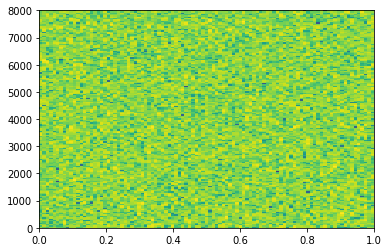

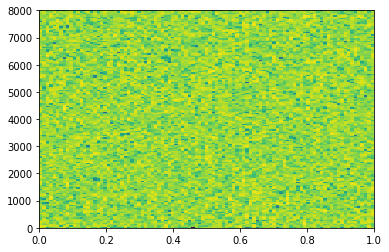

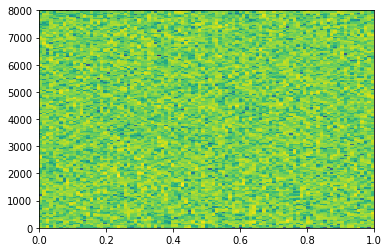

In [17]:
# check the result

sample = np.take(np.asarray(rand_noise), np.random.choice(range(0,1900), size=(3,)), axis=0)

for arr in sample:
    plt.imshow(arr,
           origin='lower',
           aspect='auto',
           extent=[0.0, 1.0, 0, 8000])
    plt.show()

In [18]:
# create noise numpy arrays

np_noise_examples = np.expand_dims(np.stack(rand_noise, axis=0), axis=3)

label_10 = [0] * NUM_CLASSES
label_10[10] = 1 # noise would be class_10

np_noise_labels = np.stack([label_10 for _ in range(np_noise_examples.shape[0])], axis=0)

In [19]:
print(np_noise_examples.shape)
print(np_noise_labels.shape)

(2000, 161, 99, 1)
(2000, 11)


### Create numpy train examples

In [20]:
# function to create numpy train data

def create_data(train_data, enum_dict, sample_rate=16000):
    
    specs = []

    for wav, direct in zip(train_data['wav'], train_data['label']):
        sample_rate, samples = wf.read(os.path.join(train_dir, direct, wav))
        log_spec = log_spectrogram(samples, sample_rate, spec_only=True)
        specs.append(log_spec)
    
    train_examples = np.expand_dims(np.stack(specs, axis=0), axis=3)
    
    enum_labels = {val: key for (key, val) in enum_dict.items()}
    one_hot_labels = []
    
    # onehot encode labels
    for label in train_data['label']:
        x = [0] * NUM_CLASSES
        x[enum_labels[label]] = 1
        one_hot_labels.append(x)
    
    train_labels = np.asarray(one_hot_labels, dtype=np.float32)
    
    return train_examples, train_labels

In [21]:
# get train numpy arrays

np_examples, np_labels = create_data(train_data, enum_dict)

### Balance dataset

In [22]:
# balance dataset
# add noise arrays

np_examples = np.concatenate((np_examples, np_noise_examples), axis=0)
np_labels = np.concatenate((np_labels, np_noise_labels), axis=0)

In [23]:
# shuffle dataset

arr = np.arange(0, np_examples.shape[0], dtype=int)
np.random.shuffle(arr)

np_examples = np_examples[arr]
np_labels = np_labels[arr]

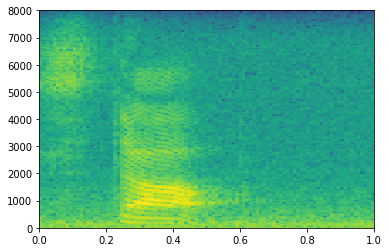

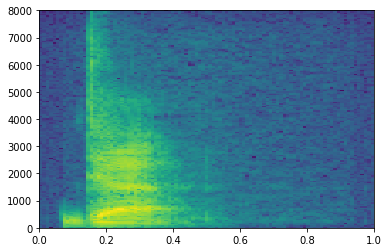

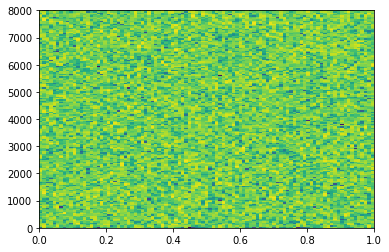

In [24]:
# get sample of 3 spectograms and plot them

sample = np.take(np_examples, np.random.choice(range(0, np_examples.shape[0] - 1), size=(3,)), axis=0)

for arr in sample:
    plt.imshow(np.squeeze(arr),
           origin='lower',
           aspect='auto',
           extent=[0.0, 1.0, 0, 8000])
    plt.show()

### Get train and validation arrays

In [25]:
# split data

RATIO = 0.8

size = round(np_examples.shape[0] * RATIO)

train_examples = np_examples[:size]
valid_examples = np_examples[size:]

train_labels = np_labels[:size]
valid_labels = np_labels[size:]

In [26]:
print(train_examples.shape)
print(train_labels.shape)

(20546, 161, 99, 1)
(20546, 11)


### CNN model

In [52]:
def cnn_model_fn(features, labels, mode, params):
    
    conv_layer_1 = tf.layers.conv2d(
        inputs=features['x'],
        filters=8,
        kernel_size=[2, 2],
        strides=1,
        padding='valid',
        activation=tf.nn.relu)
    
    conv_layer_2 = tf.layers.conv2d(
        inputs=conv_layer_1,
        filters=16,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_1 = tf.layers.average_pooling2d(
        inputs=conv_layer_2,
        pool_size=[2, 2],
        strides=2)
    
    conv_layer_3 = tf.layers.conv2d(
        inputs=pool_layer_1,
        filters=32,
        kernel_size=[2, 2],
        strides=1,
        padding='same',
        activation=tf.nn.relu)

    conv_layer_4 = tf.layers.conv2d(
        inputs=conv_layer_3,
        filters=64,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_2 = tf.layers.average_pooling2d(
        inputs=conv_layer_4,
        pool_size=[2, 2],
        strides=2)
    
    conv_layer_5 = tf.layers.conv2d(
        inputs=pool_layer_2,
        filters=128,
        kernel_size=[2, 2],
        strides=1,
        padding='same',
        activation=tf.nn.relu)

    conv_layer_6 = tf.layers.conv2d(
        inputs=conv_layer_5,
        filters=256,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_3 = tf.layers.max_pooling2d(
        inputs=conv_layer_6,
        pool_size=[2, 2],
        strides=2)
    
    reshape_layer = tf.layers.flatten(
        pool_layer_3)
    
    dense_layer_1 = tf.layers.dense(
        inputs=reshape_layer,
        units=1000,
        activation=tf.nn.relu)
    
    is_train = False
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_train = True
    
    dropout_layer = tf.layers.dropout(
        inputs=dense_layer_1,
        rate=0.2,
        training=is_train)
    
    logits_layer = tf.layers.dense(
        inputs=dropout_layer,
        units=NUM_CLASSES)
    
    classes = tf.argmax(
        input=logits_layer,
        axis=1)
    
    probs = tf.nn.softmax(
        logits_layer, axis=1)
    
    predictions = {
        'classes': classes,
        'probabilities': probs}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=labels,
        logits=probs)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions=probs,
        name='acc')
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(params['learning_rate']).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'acc':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Train function

In [28]:
# train function

def train_and_evaluate(estimator, steps=10, epochs=1):

    all_train_log = []
    all_validate_log = []
    
    for _ in range(epochs):
        
        for step in range(steps):
            
            estimator.train(input_fn=train_input_fn)
            
            train_log = estimator.evaluate(input_fn=eval_input_fn)
            print('STEP: {} of {}'.format(step + 1, steps))
            print('TRAIN: acc={:.3f} loss={:.3f}'.format(train_log['acc'], train_log['loss']))
            
            validate_log = estimator.evaluate(input_fn=validate_input_fn)
            print('VALID: acc={:.3f} loss={:.3f}'.format(validate_log['acc'], validate_log['loss']))
            
            all_train_log.append(train_log)
            all_validate_log.append(validate_log)
            
    return all_train_log, all_validate_log

### Train

In [29]:
# init logs

all_train_log = []
all_validate_log = []

In [54]:
# HYPERS

LEARN_RATE = 0.0005
BATCH_SIZE = 10
STEPS = 1
OUTDIR = './speech_train_data'


# INPUT FUNCTIONS

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

validate_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':valid_examples},
    y=valid_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)


# ESTIMATOR

cnn_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir=OUTDIR,
    params={'batch_size':BATCH_SIZE,
           'learning_rate':LEARN_RATE})


# TRAIN

gc.collect()

train_log, validate_log = train_and_evaluate(cnn_classifier, steps=STEPS)

all_train_log.extend(train_log)
all_validate_log.extend(validate_log)

STEP: 1 of 1
TRAIN: acc=0.879 loss=1.647
VALID: acc=0.871 loss=1.661


### Plot acc and loss

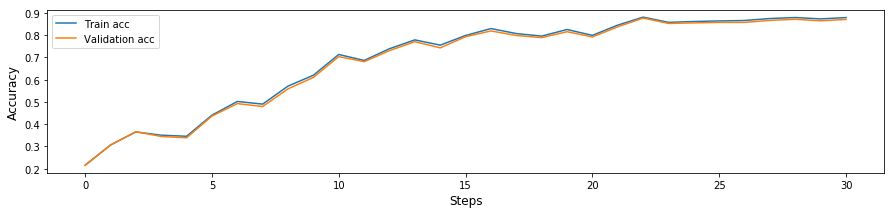

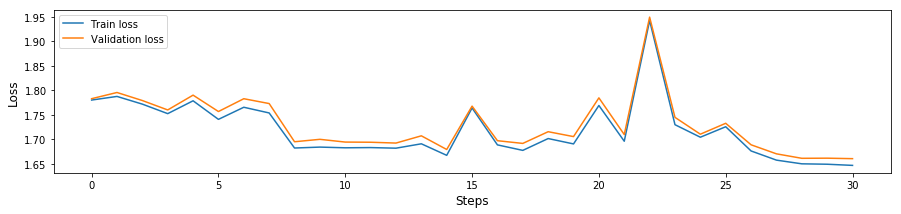

In [55]:
train_acc = [i['acc'] for i in all_train_log]
valid_acc = [i['acc'] for i in all_validate_log]

train_loss = [i['loss'] for i in all_train_log]
valid_loss = [i['loss'] for i in all_validate_log]

plt.figure(figsize=(15, 3))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train acc', 'Validation acc'], fontsize=10, loc='upper left')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train loss', 'Validation loss'], fontsize=10, loc='upper left')
plt.show()

### Get confusion matrix

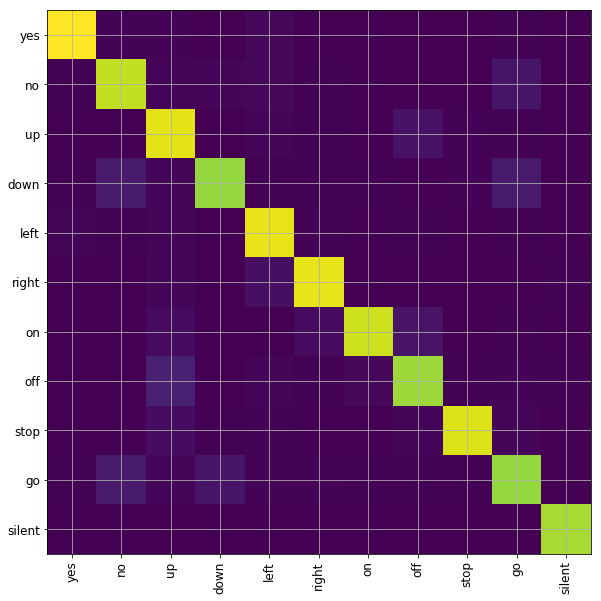

In [56]:
# build confusion matrix

conf_generator = cnn_classifier.predict(input_fn=eval_input_fn)

conf_dictlist = [next(conf_generator) for i in range(len(train_examples))]
probabilities = [conf_dictlist[i]['probabilities'] for i in range(len(train_examples))]

ticks = list(range(0, NUM_CLASSES))
tick_labels = []

for val in ticks[:NUM_CLASSES - 1]:
    tick_labels.append(enum_dict[val])
tick_labels.append('silent')

plt.figure(figsize=(10,10))
plt.yticks(ticks=ticks, labels=tick_labels, fontsize=12)
plt.xticks(ticks=ticks, labels=tick_labels, rotation='vertical', fontsize=12)
plt.grid()
plt.imshow(metrics.confusion_matrix(np.argmax(train_labels, axis=1), np.argmax(probabilities, axis=1)))

### Create test examples for predictions

In [57]:
def create_test_data(test_gen, size=1000):
    
    specs = []

    i = 0
    while i < size:
        filename = next(test_gen, None)
        if filename == None:
            break
        sample_rate, wav = wf.read(os.path.join(test_dir, filename))
        log_spec = log_spectrogram(wav, 16000, spec_only=True)
        specs.append(log_spec)
        i += 1
    
    test_examples = np.expand_dims(np.stack(specs, axis=0), axis=3)
    
    return test_examples

### Predict

In [58]:
# make predictions by 10000 samples

SIZE = 10000

test_wavs = os.listdir(test_dir)
test_generator = iter(test_wavs)

total_steps = math.ceil(len(test_wavs) / SIZE)

preds = []

for step in range(total_steps):

    print('\rStep {}/{}'.format(step, total_steps), flush=True)
    
    test_examples = create_test_data(test_generator, size=SIZE)
    
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':test_examples},
        batch_size=100,
        num_epochs=1,
        shuffle=False)

    predict_generator = cnn_classifier.predict(input_fn=predict_input_fn)

    predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

    for i in range(len(predict_dictlist)):
        x = predict_dictlist[i]['classes']
        preds.append(x)

Step 0/16
Step 1/16
Step 2/16
Step 3/16
Step 4/16
Step 5/16
Step 6/16
Step 7/16
Step 8/16
Step 9/16
Step 10/16
Step 11/16
Step 12/16
Step 13/16
Step 14/16
Step 15/16


### Create submission file

In [59]:
submission_labels = [enum_dict[x] for x in preds]

sub = pd.DataFrame()

sub['fname'] = test_wavs
sub['label'] = submission_labels

sub.to_csv('sub_6.csv', index=False)